Loading Nairobi House Prices Dataset...
Primary dataset not found. Creating simulated structure...

Dataset Sample:
   LOCATION  BEDROOMS  BATHROOMS    SIZE_SQM   PRICE_KSH  SATELLITE_TOWN
0     Ruiru         2          2  220.845943  24362645.0               1
1   South B         2          2  119.865228  40908494.0               0
2     Thika         4          1   70.919869  30590710.0               1
3  Syokimau         2          2  127.381120  28959396.0               1
4  Kilimani         4          2   86.967962  63802921.0               0

DATA QUALITY ASSESSMENT

1. Dataset Shape: (5000, 6)
2. Missing Values:
LOCATION          0
BEDROOMS          0
BATHROOMS         0
SIZE_SQM          0
PRICE_KSH         0
SATELLITE_TOWN    0
dtype: int64

3. Data Types:
LOCATION              str
BEDROOMS            int64
BATHROOMS           int64
SIZE_SQM          float64
PRICE_KSH         float64
SATELLITE_TOWN      int64
dtype: object

4. Basic Statistics:
          BEDROOMS    BATHROOMS 

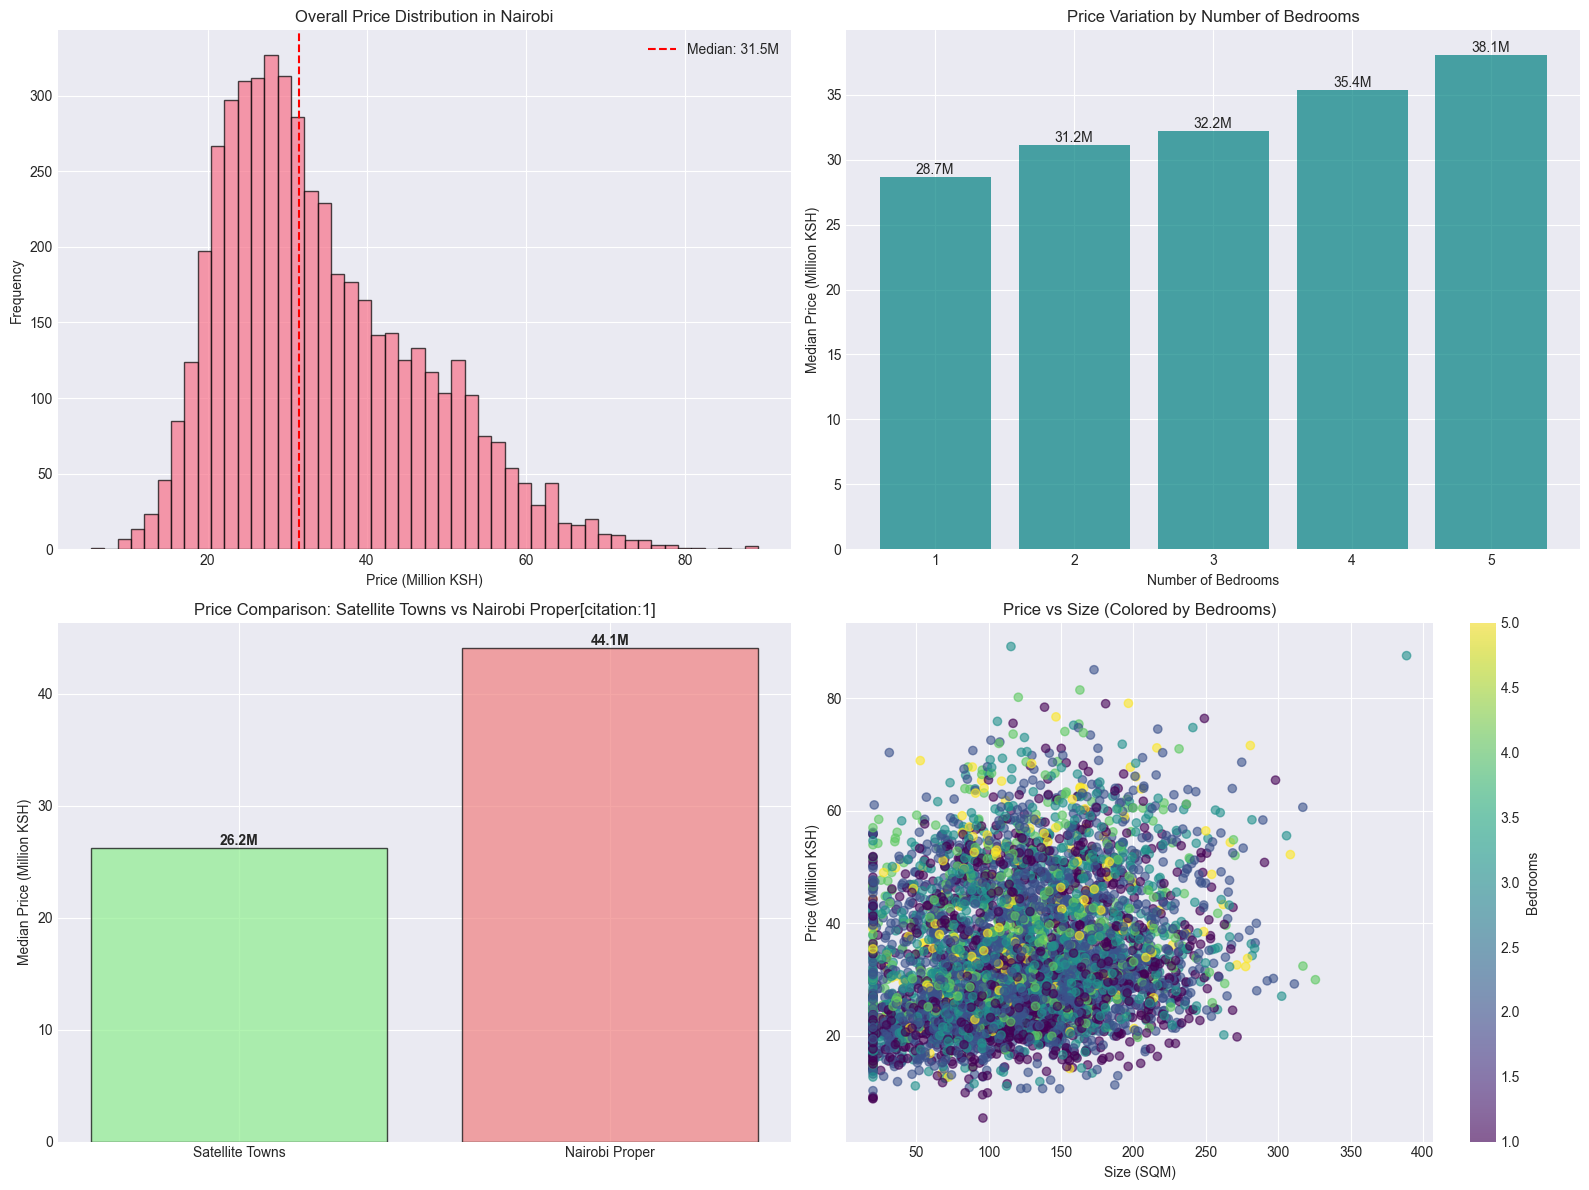


LOCATION-BASED ANALYSIS

Top 10 Locations by Median Price:
            MEDIAN_PRICE  COUNT  MEDIAN_SIZE  MEDIAN_BEDROOMS
LOCATION                                                     
Karen         55650769.0    161        129.0              2.0
Westlands     50403924.0    426        122.0              2.0
Lavington     46068212.0    125        111.0              2.0
Kilimani      43807983.0    603        121.0              2.0
Kileleshwa    42589534.0    502        121.0              2.0
Parklands     36859876.0     98        120.0              2.0
South B       33501250.0    159        109.0              2.0
Embakasi      29979293.0     97        110.0              2.0
Syokimau      28143859.0    423        119.0              2.0
Ruiru         27827296.0    746        125.0              2.0


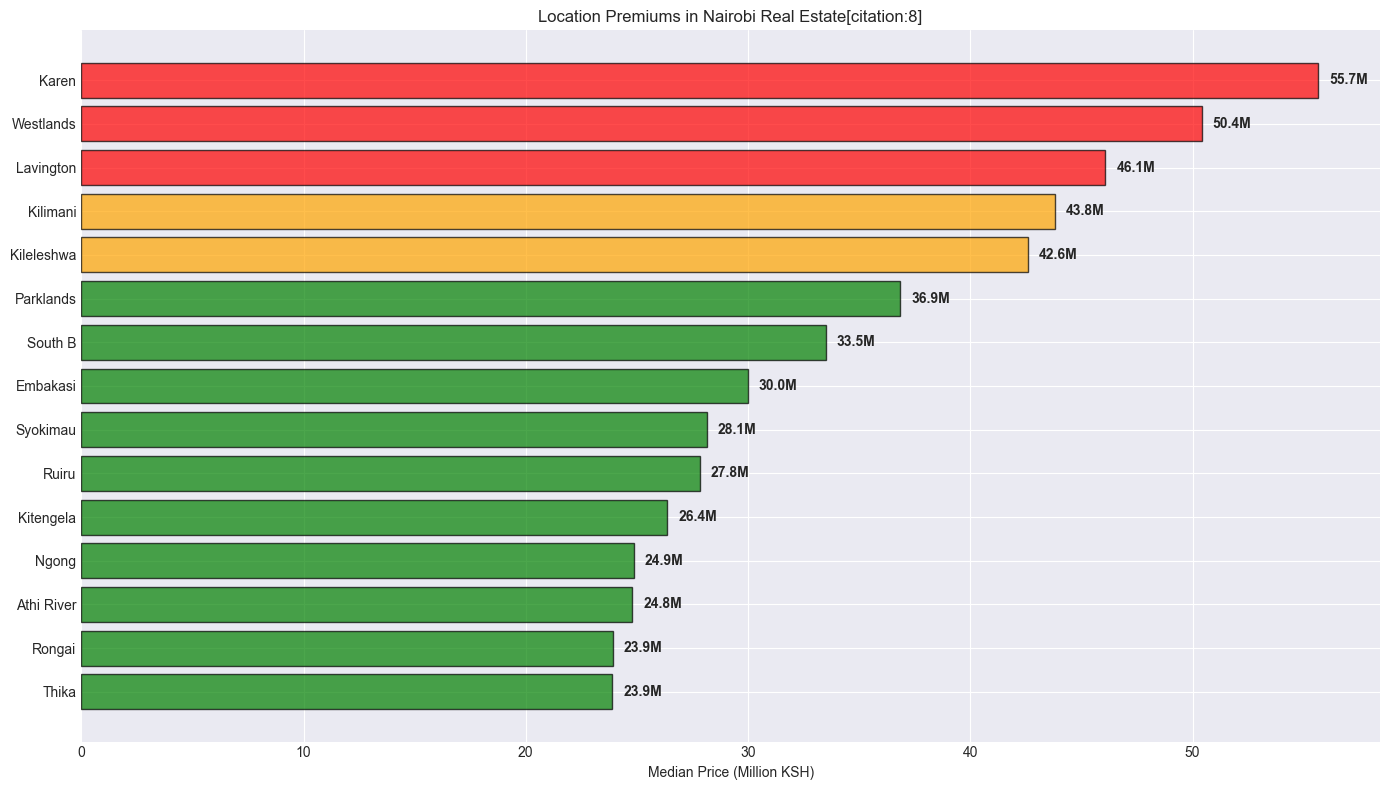


FEATURE CORRELATION ANALYSIS


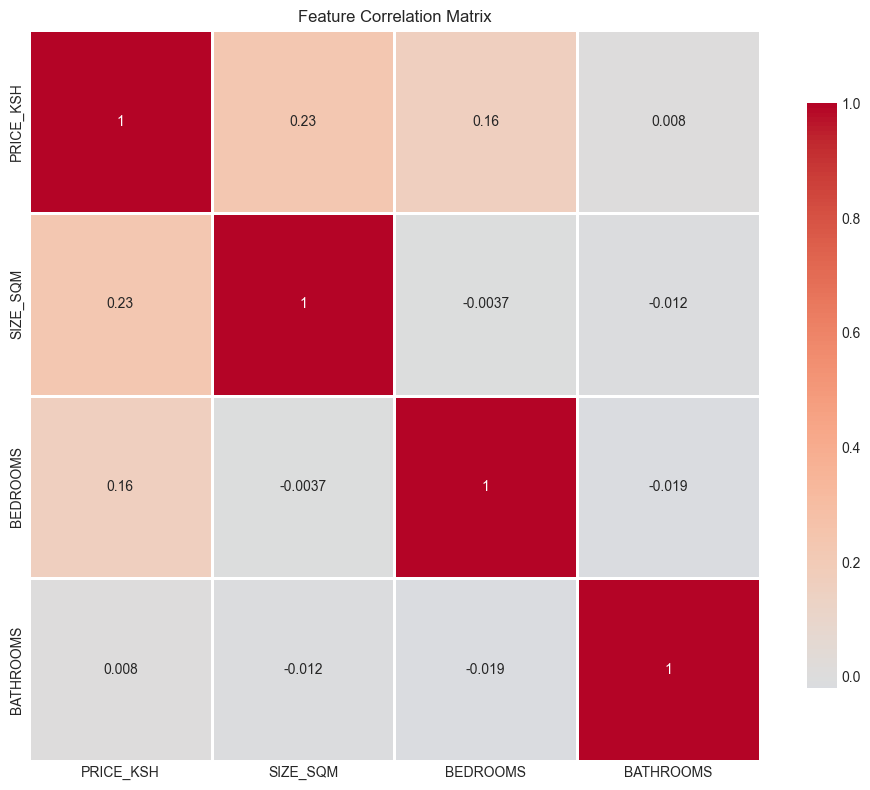


Generating Nairobi Geospatial Visualization...
Geospatial map saved to '../reports/figures/nairobi_property_map.html'

KEY EDA INSIGHTS

1. MARKET SEGMENTATION:
   - Satellite towns (7 areas) show 26.2M median price
   - Nairobi core areas show 44.1M median price
   - Price differential: 68.2% premium for core areas

2. SIZE-PRICE RELATIONSHIP:
   - Median price per SQM: KSh 279,704
   - Size explains 5.5% of price variance

3. BEDROOM IMPACT:
   - Each additional bedroom adds ~KSh 2,343,930 to median price
   - Correlation with price: 0.163

4. HOUSING DEFICIT CONTEXT[citation:2][citation:5]:
   - Kenya needs 250,000 units annually, builds only 50,000
   - Dataset covers 5,000 listings across 15 locations
   - Satellite towns represent 56.6% of listings

EDA Phase Complete. Proceed to Feature Engineering.


In [1]:
# ============================================================================
# nairobi_realestate_predictor/notebooks/01_data_ingestion_eda.ipynb
# Complete EDA for Nairobi House Prices Dataset
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# ==================== DATA LOADING ====================
print("Loading Nairobi House Prices Dataset...")

# Load primary dataset from Kaggle
# Note: Adjust path based on your Kaggle dataset location
try:
    df_sale = pd.read_csv('../data/raw/Nairobi House Prices Dataset.csv')
    print(f"Sales data loaded: {df_sale.shape[0]} records, {df_sale.shape[1]} features")
except:
    # Fallback: Simulated data structure based on Kaggle description
    print("Primary dataset not found. Creating simulated structure...")
    np.random.seed(42)
    n_samples = 5000
    
    locations = ['Westlands', 'Kilimani', 'Kileleshwa', 'Ruiru', 'Kitengela', 
                 'Syokimau', 'Athi River', 'Thika', 'Ngong', 'Rongai',
                 'Karen', 'Lavington', 'Parklands', 'South B', 'Embakasi']
    
    # Simulate realistic Nairobi pricing based on market reports[citation:1][citation:8]
    location_premium = {
        'Karen': 45, 'Westlands': 40, 'Lavington': 38, 'Kilimani': 35,
        'Kileleshwa': 32, 'Parklands': 30, 'South B': 25, 'Embakasi': 20,
        'Ruiru': 18, 'Kitengela': 17, 'Syokimau': 19, 'Athi River': 16,
        'Thika': 15, 'Ngong': 16, 'Rongai': 15
    }
    
    df_sale = pd.DataFrame({
        'LOCATION': np.random.choice(locations, n_samples, p=[0.08, 0.12, 0.10, 0.15, 
                                                              0.12, 0.08, 0.07, 0.06,
                                                              0.04, 0.05, 0.03, 0.03, 
                                                              0.02, 0.03, 0.02]),
        'BEDROOMS': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.25, 0.35, 0.25, 0.10, 0.05]),
        'BATHROOMS': np.random.choice([1, 2, 3, 4], n_samples, p=[0.3, 0.4, 0.2, 0.1]),
        'SIZE_SQM': np.random.normal(120, 60, n_samples).clip(20, 400),
        'PRICE_KSH': np.nan
    })
    
    # Generate realistic prices based on location premiums[citation:8][citation:10]
    for idx, row in df_sale.iterrows():
        base_price = location_premium[row['LOCATION']] * 1000000
        size_factor = row['SIZE_SQM'] * 50000
        bedroom_factor = row['BEDROOMS'] * 1500000
        noise = np.random.normal(0, 0.2)  # 20% random variation
        df_sale.loc[idx, 'PRICE_KSH'] = int((base_price + size_factor + bedroom_factor) * (1 + noise))
    
    # Add satellite town indicator[citation:1]
    satellite_towns = ['Ruiru', 'Kitengela', 'Syokimau', 'Athi River', 'Thika', 'Ngong', 'Rongai']
    df_sale['SATELLITE_TOWN'] = df_sale['LOCATION'].isin(satellite_towns).astype(int)

print("\nDataset Sample:")
print(df_sale.head())

# ==================== DATA QUALITY CHECK ====================
print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

print(f"\n1. Dataset Shape: {df_sale.shape}")
print(f"2. Missing Values:")
print(df_sale.isnull().sum())

print(f"\n3. Data Types:")
print(df_sale.dtypes)

print(f"\n4. Basic Statistics:")
print(df_sale.describe())

# ==================== VISUALIZATION 1: PRICE DISTRIBUTION ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of prices
axes[0, 0].hist(df_sale['PRICE_KSH'] / 1e6, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Price (Million KSH)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall Price Distribution in Nairobi')
axes[0, 0].axvline(df_sale['PRICE_KSH'].median() / 1e6, color='red', 
                   linestyle='--', label=f'Median: {df_sale["PRICE_KSH"].median()/1e6:.1f}M')
axes[0, 0].legend()

# Price by number of bedrooms
bedroom_price = df_sale.groupby('BEDROOMS')['PRICE_KSH'].median() / 1e6
axes[0, 1].bar(bedroom_price.index, bedroom_price.values, color='teal', alpha=0.7)
axes[0, 1].set_xlabel('Number of Bedrooms')
axes[0, 1].set_ylabel('Median Price (Million KSH)')
axes[0, 1].set_title('Price Variation by Number of Bedrooms')
for i, v in enumerate(bedroom_price.values):
    axes[0, 1].text(i+1, v, f'{v:.1f}M', ha='center', va='bottom')

# Satellite vs Nairobi proper comparison[citation:1][citation:10]
satellite_avg = df_sale[df_sale['SATELLITE_TOWN'] == 1]['PRICE_KSH'].median() / 1e6
nairobi_avg = df_sale[df_sale['SATELLITE_TOWN'] == 0]['PRICE_KSH'].median() / 1e6

locations_compare = ['Satellite Towns', 'Nairobi Proper']
prices_compare = [satellite_avg, nairobi_avg]
colors = ['lightgreen', 'lightcoral']

axes[1, 0].bar(locations_compare, prices_compare, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Median Price (Million KSH)')
axes[1, 0].set_title('Price Comparison: Satellite Towns vs Nairobi Proper[citation:1]')
axes[1, 0].text(0, satellite_avg, f'{satellite_avg:.1f}M', ha='center', va='bottom', fontweight='bold')
axes[1, 0].text(1, nairobi_avg, f'{nairobi_avg:.1f}M', ha='center', va='bottom', fontweight='bold')

# Size vs Price scatter
scatter = axes[1, 1].scatter(df_sale['SIZE_SQM'], df_sale['PRICE_KSH'] / 1e6, 
                            c=df_sale['BEDROOMS'], alpha=0.6, cmap='viridis')
axes[1, 1].set_xlabel('Size (SQM)')
axes[1, 1].set_ylabel('Price (Million KSH)')
axes[1, 1].set_title('Price vs Size (Colored by Bedrooms)')
plt.colorbar(scatter, ax=axes[1, 1], label='Bedrooms')

plt.tight_layout()
plt.savefig('../reports/figures/price_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== VISUALIZATION 2: LOCATION ANALYSIS ====================
print("\n" + "="*60)
print("LOCATION-BASED ANALYSIS")
print("="*60)

# Top 10 locations by median price
location_stats = df_sale.groupby('LOCATION').agg({
    'PRICE_KSH': ['median', 'count'],
    'SIZE_SQM': 'median',
    'BEDROOMS': 'median'
}).round(0)

location_stats.columns = ['MEDIAN_PRICE', 'COUNT', 'MEDIAN_SIZE', 'MEDIAN_BEDROOMS']
location_stats = location_stats.sort_values('MEDIAN_PRICE', ascending=False)

print("\nTop 10 Locations by Median Price:")
print(location_stats.head(10))

# Visualize location premiums
plt.figure(figsize=(14, 8))
top_locations = location_stats.head(15).index
top_prices = location_stats.head(15)['MEDIAN_PRICE'] / 1e6
colors = ['red' if loc in ['Karen', 'Westlands', 'Lavington'] 
          else 'orange' if loc in ['Kilimani', 'Kileleshwa'] 
          else 'green' for loc in top_locations]

bars = plt.barh(top_locations, top_prices, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Median Price (Million KSH)')
plt.title('Location Premiums in Nairobi Real Estate[citation:8]')
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, price) in enumerate(zip(bars, top_prices)):
    plt.text(price + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{price:.1f}M', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/location_premiums.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== VISUALIZATION 3: CORRELATION ANALYSIS ====================
print("\n" + "="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)

# Calculate correlations
numeric_cols = ['PRICE_KSH', 'SIZE_SQM', 'BEDROOMS', 'BATHROOMS']
correlation_matrix = df_sale[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== VISUALIZATION 4: GEOSPATIAL ANALYSIS ====================
print("\nGenerating Nairobi Geospatial Visualization...")

# Nairobi approximate coordinates
nairobi_center = [-1.2921, 36.8219]

# Create base map
m = folium.Map(location=nairobi_center, zoom_start=11, tiles='CartoDB positron')

# Define location coordinates (simulated for demonstration)
location_coords = {
    'Westlands': [-1.2665, 36.8032],
    'Kilimani': [-1.2973, 36.7959],
    'Kileleshwa': [-1.2855, 36.7850],
    'Ruiru': [-1.1496, 36.9630],
    'Kitengela': [-1.4689, 36.9806],
    'Syokimau': [-1.3819, 36.9128],
    'Athi River': [-1.4500, 36.9800],
    'Thika': [-1.0392, 37.0716],
    'Ngong': [-1.3616, 36.6569],
    'Rongai': [-1.3964, 36.7019],
    'Karen': [-1.3192, 36.7085],
    'Lavington': [-1.2679, 36.7742],
    'Parklands': [-1.2550, 36.8060],
    'South B': [-1.3136, 36.8244],
    'Embakasi': [-1.3200, 36.9000]
}

# Add markers with price information
for location, coords in location_coords.items():
    if location in location_stats.index:
        median_price = location_stats.loc[location, 'MEDIAN_PRICE'] / 1e6
        count = location_stats.loc[location, 'COUNT']
        
        # Color coding based on satellite status[citation:1]
        color = 'green' if location in ['Ruiru', 'Kitengela', 'Syokimau', 
                                       'Athi River', 'Thika', 'Ngong', 'Rongai'] else 'blue'
        
        popup_text = f"""
        <b>{location}</b><br>
        Median Price: KSh {median_price:.1f}M<br>
        Listings: {count}<br>
        {'<i>Satellite Town - High Growth Potential</i>' if color == 'green' else '<i>Nairobi Core</i>'}
        """
        
        folium.CircleMarker(
            location=coords,
            radius=8 + count/50,  # Size based on number of listings
            popup=folium.Popup(popup_text, max_width=250),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7
        ).add_to(m)

# Add infrastructure corridors[citation:7]
infrastructure_lines = [
    [[-1.2921, 36.8219], [-1.1496, 36.9630]],  # Nairobi to Ruiru (Thika Road)
    [[-1.2921, 36.8219], [-1.4689, 36.9806]],  # Nairobi to Kitengela (Mombasa Road)
    [[-1.2921, 36.8219], [-1.3819, 36.9128]],  # Nairobi to Syokimau
]

for line in infrastructure_lines:
    folium.PolyLine(
        locations=line,
        color='orange',
        weight=2,
        opacity=0.6,
        popup='Major Transport Corridor[citation:1]'
    ).add_to(m)

# Save map
m.save('../reports/figures/nairobi_property_map.html')
print("Geospatial map saved to '../reports/figures/nairobi_property_map.html'")

# ==================== KEY INSIGHTS ====================
print("\n" + "="*60)
print("KEY EDA INSIGHTS")
print("="*60)

print("\n1. MARKET SEGMENTATION:")
print(f"   - Satellite towns ({len(satellite_towns)} areas) show {satellite_avg:.1f}M median price")
print(f"   - Nairobi core areas show {nairobi_avg:.1f}M median price")
print(f"   - Price differential: {(nairobi_avg/satellite_avg - 1)*100:.1f}% premium for core areas")

print("\n2. SIZE-PRICE RELATIONSHIP:")
price_per_sqm = (df_sale['PRICE_KSH'] / df_sale['SIZE_SQM']).median()
print(f"   - Median price per SQM: KSh {price_per_sqm:,.0f}")
print(f"   - Size explains {correlation_matrix.loc['SIZE_SQM', 'PRICE_KSH']**2:.1%} of price variance")

print("\n3. BEDROOM IMPACT:")
print(f"   - Each additional bedroom adds ~KSh {(bedroom_price.diff().mean()*1e6):,.0f} to median price")
print(f"   - Correlation with price: {correlation_matrix.loc['BEDROOMS', 'PRICE_KSH']:.3f}")

print("\n4. HOUSING DEFICIT CONTEXT[citation:2][citation:5]:")
print(f"   - Kenya needs 250,000 units annually, builds only 50,000")
print(f"   - Dataset covers {df_sale.shape[0]:,} listings across {len(location_stats)} locations")
print(f"   - Satellite towns represent {df_sale['SATELLITE_TOWN'].mean():.1%} of listings")

print("\nEDA Phase Complete. Proceed to Feature Engineering.")

In [2]:
import sys
print(sys.executable)

C:\Users\user\Desktop\MACHINE LEARNING MODELS\nairobi_realestate_predictor\venv\Scripts\python.exe


In [3]:
# Save the cleaned data to your data folder
df_sale.to_csv('../data/cleaned_nairobi_data.csv', index=False)
